In [ ]:
from gpt3forchem.data import get_uspto_yield_data
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.input import create_reaction_yield_prompts

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

In [ ]:
data = get_uspto_yield_data()

In [ ]:
data

,reaction_smiles,yield,mass,yield_text,dl:documentId,dl:paragraphNum,dl:paragraphText,paragraph_without_yield,paragraph_without_yield_and_charac,dl:headingText
0,[C:1]([O:5][C:6](=[O:19])[NH:7][C:8]1[C:13]([F...,86.0,0.00076,"refining by means of column chromatography, 0....",US20130317023A1,151,"After dissolving the tert-butyl-2,6-difluoro-3...","After dissolving the tert-butyl-2,6-difluoro-3...","After dissolving the tert-butyl-2,6-difluoro-3...",NaN
1,[NH3:1].CO.C([O:6][C:7]([C:9]1[CH:14]=[C:13]([...,65.0,0.26700,to provide 0.267 g of 4-chloro-6-[3-(4-fluoro-...,US20130303526A1,926,"In a 50-ml vial with a screw-top septum, 4-chl...","In a 50-ml vial with a screw-top septum, 4-chl...","In a 50-ml vial with a screw-top septum, 4-chl...",NaN
2,[CH2:1]([C:7]1([CH2:24][CH2:25][CH2:26][CH2:27...,88.9,48.00000,to thereby obtain 48 g of a mixture of N-tert-...,US20130225834A1,85,"In a 500 mL round flask, 9,9-dihexyl-2-methyl-...","In a 500 mL round flask, 9,9-dihexyl-2-methyl-...","In a 500 mL round flask, 9,9-dihexyl-2-methyl-...",NaN
3,[CH3:1][C:2]1[CH2:3][C:4]2[C:5]([CH:19]=1)=[CH...,91.8,21.00000,to thereby obtain 21.0 g of a mixture of N-ter...,US20130225834A1,96,"In a 500 mL round flask, 2,9,9-trimethyl-3,9-d...","In a 500 mL round flask, 2,9,9-trimethyl-3,9-d...","In a 500 mL round flask, 2,9,9-trimethyl-3,9-d...",NaN
4,[CH3:1][C:2]1[CH2:3][C:4]2[C:5]([CH:45]=1)=[CH...,92.7,5.50000,to thereby obtain 5.5 g of a mixture of N-tert...,US20130225834A1,111,"In a 250 mL round flask, 2-methyl-9.9-ditetrad...","In a 250 mL round flask, 2-methyl-9.9-ditetrad...","In a 250 mL round flask, 2-methyl-9.9-ditetrad...",NaN
...,...,...,...,...,...,...,...,...,...,...
1550,[CH3:1][O:2][C:3]1[CH:8]=[CH:7][C:6]([CH2:9][C...,89.0,74.00000,the precipitate produced,US20040186310A1,43,50 g (0.34 mole) of p-methoxyphenylacetonitril...,50 g (0.34 mole) of p-methoxyphenylacetonitril...,50 g (0.34 mole) of p-methoxyphenylacetonitril...,NaN
1551,[CH3:1][O:2][C:3]1[CH:8]=[CH:7][C:6]([CH2:9][C...,72.0,30.00000,the precipitate produced,US20040186310A1,44,"25 g (0.17 mole) p-methoxyphenylacetonitrile, ...","25 g (0.17 mole) p-methoxyphenylacetonitrile, ...","25 g (0.17 mole) p-methoxyphenylacetonitrile, ...",NaN
1552,[CH3:1][O:2][C:3]1[CH:8]=[CH:7][C:6]([CH2:9][C...,34.2,25.20000,"to yield 25.2 g of the target compound, 1-[cya...",US20040186310A1,45,50 g (0.34 mole) of p-methoxyphenylacetonitril...,50 g (0.34 mole) of p-methoxyphenylacetonitril...,50 g (0.34 mole) of p-methoxyphenylacetonitril...,NaN
1553,[H-].[Na+].[CH3:3][O:4][C:5]1[CH:12]=[CH:11][C...,40.0,3.46900,5-(4-methoxy-benzyloxy)-pentan-1-ol (3.469 g) ...,US20040092581A1,135,"The diol 26 (8.17 g, 78.44 mmol) in 12 ml dry ...","The diol 26 (8.17 g, 78.44 mmol) in 12 ml dry ...","The diol 26 (8.17 g, 78.44 mmol) in 12 ml dry ...",NaN


In [ ]:
prompts = create_reaction_yield_prompts(data)

In [ ]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.2)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-11-49-26'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-11-49-26', test_prompts)

In [ ]:
predictions = [extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])]

In [ ]:
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

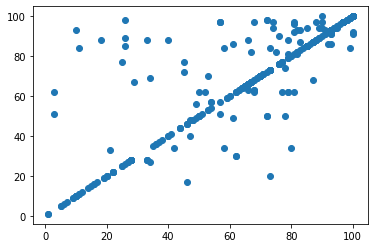

In [ ]:
plt.scatter(true, predictions)

In [ ]:
r2_score(true, predictions)

0.6838949660776262

### can this be data leakage?

First, check if there are duplicated reaction SMILES.

In [ ]:
len(data) - len(data['reaction_smiles'].unique())

846

ok, there are several duplicates

now, let's try to be more careful here and just split the reaction SMILES into train and test sets.

In [ ]:
train_reaction_smiles, test_reaction_smiles = train_test_split(data['reaction_smiles'].unique(), train_size=0.8)

In [ ]:
train_data = data[data['reaction_smiles'].isin(train_reaction_smiles)]
test_data = data[data['reaction_smiles'].isin(test_reaction_smiles)]

In [ ]:
train_prompts = create_reaction_yield_prompts(train_data) 
test_prompts = create_reaction_yield_prompts(test_data)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-13-19-56'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-13-19-56', test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

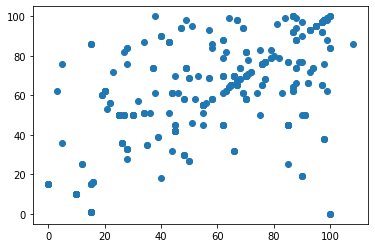

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

0.19808815914679423

In [ ]:
len(train_data)

1218

### Now, add reaction SMILES

In [ ]:
train_prompts = create_reaction_yield_prompts(train_data, include_reaction_smiles=True) 
test_prompts = create_reaction_yield_prompts(test_data, include_reaction_smiles=True)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-13-43-43'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-13-43-43', test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

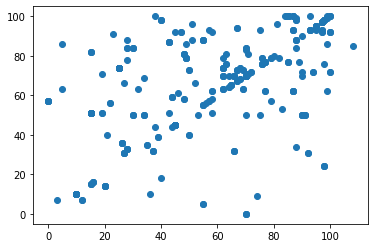

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

0.10309063282769448

In [ ]:
len(train_data)

1218